In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np


In [2]:
df = pd.read_csv("../data/data_new.csv")

In [3]:
df.shape

(56443, 3)

In [4]:
df.head

<bound method NDFrame.head of         ir1  ir2  degree
0       0.0  0.0       1
1      20.3  2.7       1
2      20.3  2.7       3
3      20.3  2.7       3
4      20.4  2.6       3
...     ...  ...     ...
56438  21.9  6.5       3
56439  22.2  6.8       3
56440  22.2  6.8       3
56441  22.2  6.8       3
56442  22.2  6.8       3

[56443 rows x 3 columns]>

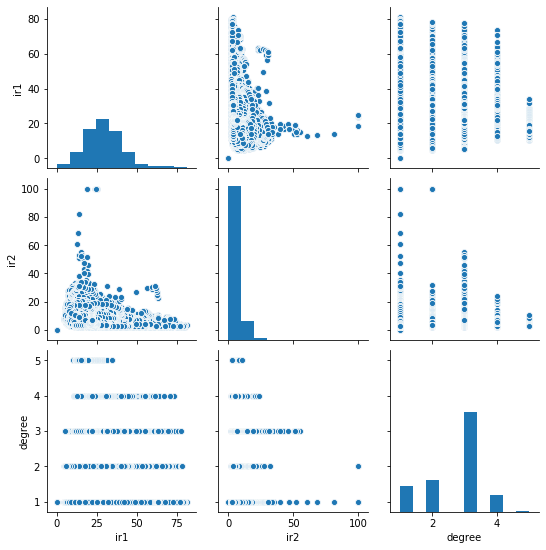

In [5]:
sns.pairplot(df, diag_kind='hist')

plt.show()

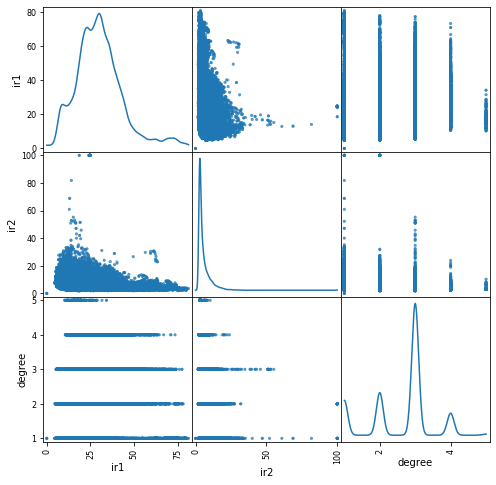

In [6]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

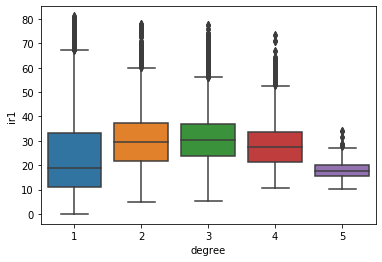

In [19]:

sns.boxplot(x="degree", y="ir1", data=df)

plt.show()


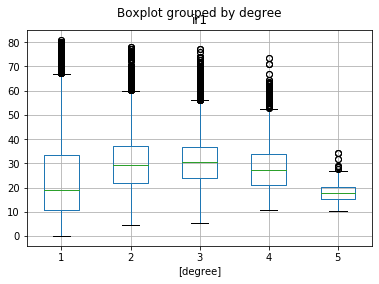

In [20]:
# Grouped boxplots by pandas

df.boxplot(column=["ir1"], by=["degree"])

plt.show()


# Normalization

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(df)
df_n = pd.DataFrame(scaler.transform(df),columns=['ir_L', 'ir_R', 'degree'])

In [ ]:
df_n

# Split data

In [16]:
# Original Data
df_inputs = df.loc[:,['ir1', 'ir2']]
df_outputs = df.loc[:,['degree']]

# Normalized Data
# df_inputs = df_n.loc[:,['ir_L', 'ir_R']]
# df_outputs = df_n.loc[:,['degree']]

inputs = np.array(df_inputs)
outputs = np.array(df_outputs)

In [17]:
num_data = len(inputs)
TRAIN_SPLIT = int(0.6 * num_data)
TEST_SPLIT = int(0.2 * num_data + TRAIN_SPLIT)

In [18]:
inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

# Random Forest Classificationn

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(inputs_train, outputs_train)

/Users/peter/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=123456,
                       verbose=0, warm_start=False)

In [30]:
from sklearn.metrics import accuracy_score

predicted = rf.predict(inputs_test)
accuracy = accuracy_score(outputs_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.828
Mean accuracy score: 0.503


# Multiple Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(inputs_train, outputs_train)

In [ ]:
# The coefficients
print('Coefficients: \n', mlr.coef_)

# mean square error
print("RSS: %.2f" % np.mean((mlr.predict(inputs_test) - outputs_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % mlr.score(inputs_test, outputs_test))

In [ ]:
outputs_predict = mlr.predict(inputs_test)

In [ ]:
plt.scatter(outputs_test, outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

# DNN

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = inputs_train.shape[1]))
model.add(tf.keras.layers.Dense(50, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.2))
model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.2))

model.add(tf.keras.layers.Dense(1, activation='relu'))



# model.compile(optimizer='adam', loss='mae', metrics=['mae']) # mse / mae
model.compile(optimizer='adam', loss='mse', metrics=['mse']) # mse / mae
model.summary()

In [ ]:
history = model.fit(inputs_train, outputs_train, epochs=1, batch_size=1000, validation_data=(inputs_validate, outputs_validate))

In [ ]:
outputs_predict = model.predict(inputs_test)

In [ ]:
plt.scatter(outputs_test, outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("DNN(Regression)")
plt.show()

# Feature 추가(mot_L, mot_R)

In [ ]:
def chdeg(degree_original):
    degree = ((degree_original - 50)*1.5)//1
    if degree <= 0:
        left = 25
        right = 25 + abs(degree)
    else:
        left = 25 - abs(degree)
        right = 25
    return left, right

left = []
right = []
for i in range(len(df)):
    left.append(chdeg(df['degree'][i])[0])
    right.append(chdeg(df['degree'][i])[1])
    
df['mot_L'] = left
df['mot_R'] = right

In [ ]:
sns.pairplot(df, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Feature 추가(ir distance 차이, 비율)

### ir 좌우 차이

In [ ]:
df['ir_R-L'] = df['ir_R'] - df['ir_L']
df['ir_L/R'] = df['ir_L'] / df['ir_R'] 
df

In [ ]:
sns.pairplot(df, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Except degree under 10 over 90 data

In [ ]:
df.sort_values(by=['degree'])

In [ ]:
df_s = df.loc[(10 < df['degree']) & (df['degree'] < 90), : ]

In [ ]:
sns.pairplot(df_s, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df_s, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# exclude degree over 50

In [ ]:
df_d = df.loc[df['degree'] < 50, : ]
df_d

In [ ]:
sns.pairplot(df_d, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df_d, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Time stamp 설정

In [ ]:
# Time Stamp를 지정하여 그 안의 값들에 대해 대표값으로 데이터를 구성
# 대표값은 평균(averave), 중앙값(median), 최빈값(mode) 중 평균값과 중앙값을 우선적으로 테스트한다.

In [ ]:
df

In [ ]:
frame = 5
length = len(df)
df_frame = pd.DataFrame(columns=['ir_L', 'ir_R', 'degree', 'mot_L', 'mot_R', 'ir_R-L', 'ir_L/R'])
ir_L, ir_R, degree, mot_L, mot_R, ir_RL, ir_LR = [], [], [], [], [], [], []

for i in range(length//frame):
    a = i*frame
    b = (i+1)*frame
    ir_L.append(np.median(df['ir_L'][a:b]))
    ir_R.append(np.median(df['ir_R'][a:b]))
    degree.append(np.median(df['degree'][a:b]))
    mot_L.append(np.median(df['mot_L'][a:b]))
    mot_R.append(np.median(df['mot_R'][a:b]))
    ir_RL.append(np.median(df['ir_R-L'][a:b]))
    ir_LR.append(np.median(df['ir_L/R'][a:b]))
df_frame['ir_L'] = ir_L
df_frame['ir_R'] = ir_R
df_frame['degree'] = degree
df_frame['mot_L'] = mot_L
df_frame['mot_R'] = mot_R
df_frame['ir_R-L'] = ir_RL
df_frame['ir_L/R'] = ir_LR

In [ ]:
df_frame

In [ ]:
sns.pairplot(df_frame, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df_frame, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

In [ ]:
import tensorflow as tf

# Original Data
df_inputs = df_frame.loc[:,['ir_L', 'ir_R', 'ir_R-L', 'ir_L/R']]
df_outputs = df_frame.loc[:,['degree']]

# Normalized Data
# df_inputs = df_n.loc[:,['ir_L', 'ir_R']]
# df_outputs = df_n.loc[:,['degree']]

inputs = np.array(df_inputs)
outputs = np.array(df_outputs)

num_data = len(inputs)
TRAIN_SPLIT = int(0.6 * num_data)
TEST_SPLIT = int(0.2 * num_data + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])



model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = inputs_train.shape[1]))
model.add(tf.keras.layers.Dense(50, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.2))
# model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.2))

model.add(tf.keras.layers.Dense(1, activation='relu'))



# model.compile(optimizer='adam', loss='mae', metrics=['mae']) # mse / mae
model.compile(optimizer='adam', loss='mse', metrics=['mse']) # mse / mae
model.summary()

In [ ]:
history = model.fit(inputs_train, outputs_train, epochs=1, batch_size=1, validation_data=(inputs_validate, outputs_validate))

In [ ]:
outputs_predict = model.predict(inputs_test)

In [ ]:
plt.scatter(outputs_test, outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("DNN(Regression)")
plt.show()

In [ ]:
ir_L = 18.8
ir_R = 2.7
ir_RL = ir_R - ir_L
ir_LR = ir_L / ir_R
data = [ir_L, ir_R, ir_RL, ir_LR]
data

In [ ]:
model.predict([[data]])[0][0]

In [ ]:
from train import Model

In [ ]:
m = Model("../data/data.csv")
m.feature_engineering()
m.set_data()
m.train()

In [ ]:
plt.scatter(m.outputs_test, m.outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("DNN(Regression)")
plt.show()

In [ ]:
m.collect_data()

In [ ]:
from modicar import Car
import modi

In [ ]:
bundle = modi.MODI()
car = Car()

mot = bundle.motors[0]
ir1 = bundle.irs[0]
ir2 = bundle.irs[1]
btn = bundle.buttons[0]
dial = bundle.dials[0]

In [ ]:
car.learn()

In [ ]:
car.collect_data(mot, ir1, ir2, btn, dial)

In [ ]:
car.start(mot, ir1, ir2)